In [2]:
from matplotlib import pyplot as plt
import os
from scipy.io.wavfile import read
import scipy
from scipy import stats
import numpy as np
import torch
import librosa
from librosa.feature import melspectrogram
import scaleogram as scg 
from logmmse import logmmse_from_file
import pywt
import pickle
import seaborn as sns
import pandas as pd
import sys
from AEspeech import AEspeech
# from phonetGM2 import Phonet
from SpecDatset import SpecDataset

C:\Users\Gabriel\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from SpecDatset import SpecDataset
import time
import torch
import numpy as np
import pandas as pd
import os
import sys
from CAE import CAEn
PATH=os.getcwd()
sys.path.append(PATH+"/toolbox/")
import traintestsplit as tts

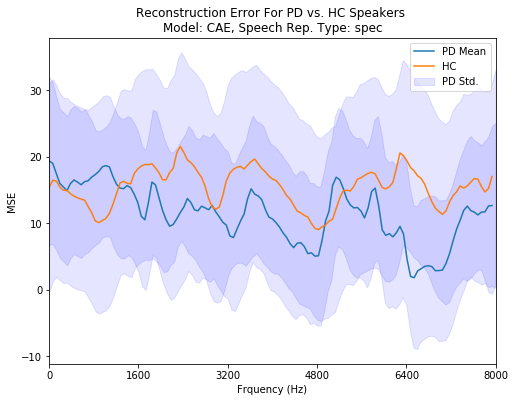

In [16]:
#Visualize reconstruction error for pd vs. hc speakers for all utterance types.
mod='CAE' #'CAE' or 'RAE'
rep='spec' #'spec' => mfccs, 'wvlt' => wavelet coefficients as features

load_path=PATH+'/pts/reconErrs/'+mod+'_'+rep+'.pickle'
with open(load_path, 'rb') as handle:
    data = pickle.load(handle)

fig,ax=plt.subplots(1,1,figsize=(8, 6))

for spk in ['pd','hc']:
    means=data[spk]['means'][0,:]
    stds=np.mean(data[spk]['stds'],axis=0)
    ttl="Reconstruction Error For PD vs. HC Speakers \nModel: "+mod+", Speech Rep. Type: "+rep

    under_line=means-stds
    over_line=means+stds

    plt.plot(means)
    plt.fill_between(np.linspace(0,len(stds),len(stds)), under_line, over_line, color='b', alpha=.1)

    plt.title(ttl)
    ax.set_xticks(np.linspace(0,len(means),6))
    ax.set_xticklabels(map(str, np.linspace(0,8000,6, dtype=np.int)))
    ax.set_xlabel('Frquency (Hz)')
    ax.set_ylabel('MSE')
    ax.set_xlim([0,len(means)])
#     ax.set_ylim([-.5,1])
    
plt.legend(['PD Mean','HC','PD Std.'])


In [7]:
scipy.stats.wilcoxon(data['pd']['means'][0,:],data['hc']['means'][0,:])

WilcoxonResult(statistic=10986.0, pvalue=4.107362794930869e-06)

In [8]:
"""
Reconstruct error for individual test speaker speech file based on CAE/RAE models for wvlt and spectral representations.
Test wav files not used for training.
"""
PATH=os.getcwd()
# path_audio=PATH+'/tedx_spanish_corpus/speech/test/'
path_audio=PATH+'/pdSpanish/speech/pataka/pd/'
spk=0
wav_file=path_audio+os.listdir(path_audio)[spk]
TIME_STEPS=256

mod='CAE' #'CAE' or 'RAE'
rep='wvlt' #'spec' => mfccs, 'wvlt' => wavelet coefficients as features

fs_in, signal=read(wav_file)

#set loop parameters
unit=256
num_files=len(os.listdir(path_audio))

save_path=PATH+'/phonCSVs/'+rep+'/'

# for mod in models:
aespeech=AEspeech(model=mod,units=unit,rep=rep)
if rep=='spec':
    mat=aespeech.compute_spectrograms(wav_file)
if rep=='wvlt':
    mat,freqs=aespeech.compute_cwt(wav_file)
    
if torch.cuda.is_available():
    mat=mat.cuda()
to,bot=aespeech.AE.forward(mat)


C:\Users\Gabriel\Anaconda3\lib\site-packages\torch\nn\functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


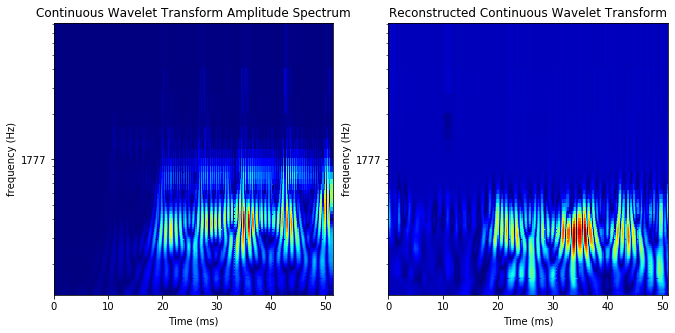

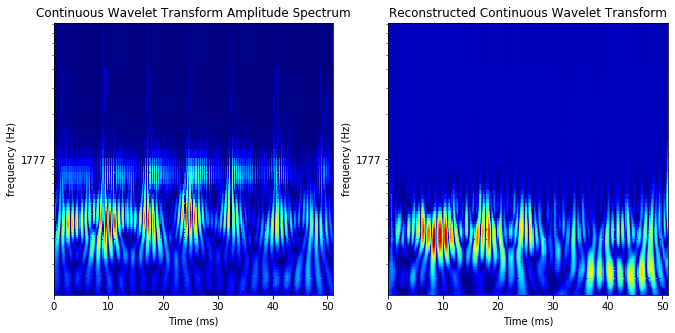

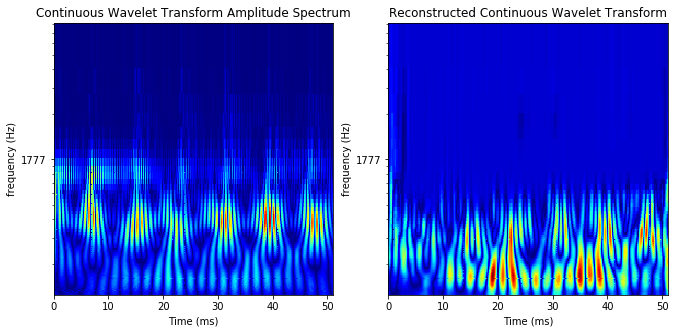

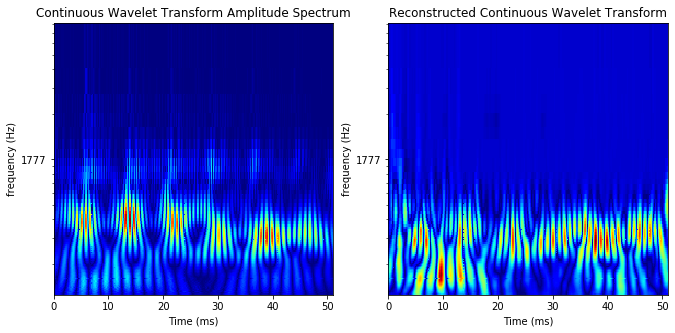

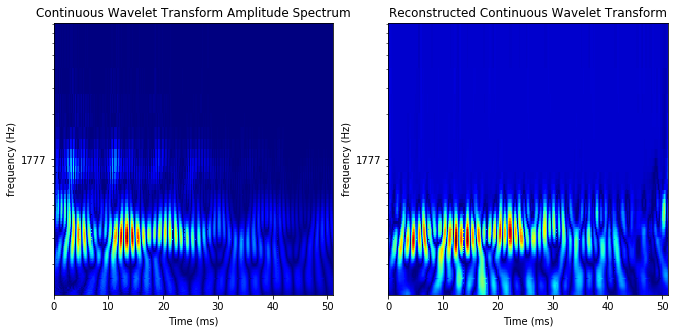

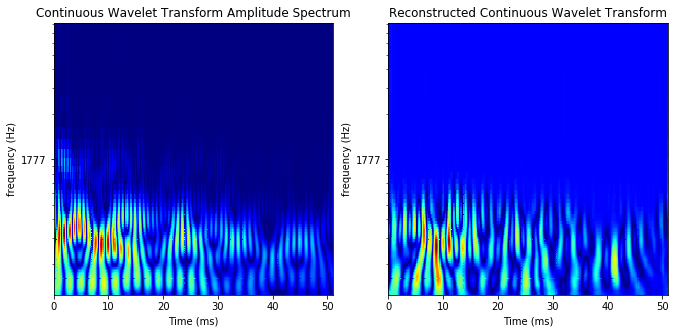

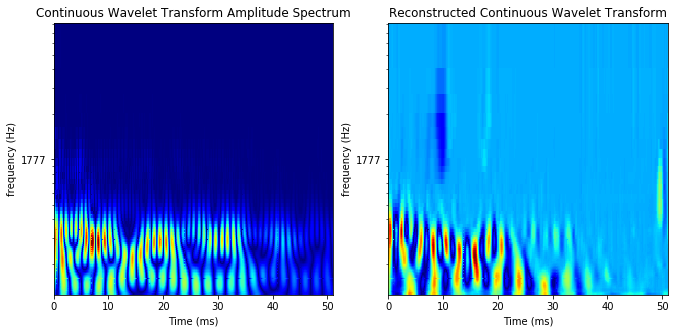

In [15]:
to=aespeech.destandard(to)
if rep=='spec':
    aespeech.show_spectrograms(mat,to)
if rep=='wvlt':
    aespeech.show_scalograms(np.arange(TIME_STEPS),coefs1=mat[48:55,:,:,:],coefs2=to[48:55,:,:,:], freqs=freqs, hop=2, yaxis='frequency', ylabel='frequency (Hz)')


(0, 256)

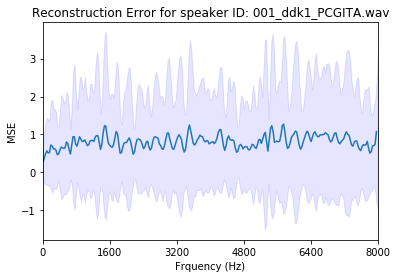

In [14]:
#Visualize individual speaker recon error
means=np.mean(np.mean((mat[:,0,:,:].detach().numpy()-to[:,0,:,:].detach().numpy())**2,axis=1),axis=0)
stds=np.std(np.mean((mat[:,0,:,:].detach().numpy()-to[:,0,:,:].detach().numpy())**2,axis=1),axis=0)
ttl="Reconstruction Error for speaker ID: "+os.listdir(path_audio)[spk]

under_line=means-stds
over_line=means+stds

fig,ax=plt.subplots(1,1)
plt.plot(means)
plt.fill_between(np.linspace(0,len(stds),len(stds)), under_line, over_line, color='b', alpha=.1)

plt.title(ttl)
ax.set_xticks(np.linspace(0,len(means),6))
ax.set_xticklabels(map(str, np.linspace(0,8000,6, dtype=np.int)))
ax.set_xlabel('Frquency (Hz)')
ax.set_ylabel('MSE')
ax.set_xlim([0,len(means)])
